In [5]:
from __future__ import print_function
import matplotlib     # These are needed to run
matplotlib.use("Agg") # the code headless.

import numpy as np
import matplotlib.pyplot as plt
import os
import sklearn
from numpy import interp
from sklearn.metrics import roc_curve, roc_auc_score
import scipy
import datetime
import tensorflow as tf
import tflearn
%matplotlib inline

/usr/lib/python2.7/dist-packages/matplotlib/__init__.py:1403: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


hdf5 is not supported on this machine (please install/reinstall h5py for optimal experience)


In [9]:
sess = tf.InteractiveSession()
tf.reset_default_graph()

# Input layer:
net = tflearn.layers.core.input_data(shape=[None,34,34,34,2])

# First layer:
net = tflearn.layers.conv.conv_3d(net, 32, [10,10,10],  activation="leaky_relu")
net = tflearn.layers.conv.max_pool_3d(net, [2,2,2], strides=[2,2,2])

# Second layer:
net = tflearn.layers.conv.conv_3d(net, 64, [5,5,5],  activation="leaky_relu")
net = tflearn.layers.conv.max_pool_3d(net, [2,2,2], strides=[2,2,2])

# Fully connected layers
net = tflearn.layers.core.fully_connected(net, 2048, activation="leaky_relu") # regularizer="L2", weight_decay=0.01,
#net = tflearn.layers.core.dropout(net, keep_prob=0.5)

net = tflearn.layers.core.fully_connected(net, 1024, activation="leaky_relu") # regularizer="L2", weight_decay=0.01,
#net = tflearn.layers.core.dropout(net, keep_prob=0.5)

net = tflearn.layers.core.fully_connected(net, 512, activation="leaky_relu") # regularizer="L2", weight_decay=0.01,
#net = tflearn.layers.core.dropout(net, keep_prob=0.5)

# Output layer:
net = tflearn.layers.core.fully_connected(net, 2, activation="softmax")

net = tflearn.layers.estimator.regression(net, optimizer='adam', learning_rate=0.0001, loss='categorical_crossentropy')
model = tflearn.DNN(net)

model.load("./models/2017-07-27_12:51:00_3d-2channel-fakedata_0-of-3.tflearn")

INFO:tensorflow:Restoring parameters from /home/mike/Documents/UoH_job/heart_cnn/models/2017-07-27_12:51:00_3d-2channel-fakedata_0-of-3.tflearn


In [12]:
shufData = np.load("./data/shufData.npy")
shufLab = np.load("./data/shufLab.npy")
shufLabOH = np.eye(2)[shufLab.astype(int)]

In [21]:
predicted = model.predict(shufData)

In [22]:
shufLab

array([ 1.,  0.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  1.,  1.,  0.,  1.,
        1.,  0.,  0.,  1.,  0.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,
        0.,  0.,  1.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,
        1.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  1.,  1.])

In [25]:
roc_auc_score(shufLab,predicted[:,1])

0.50178359096313907

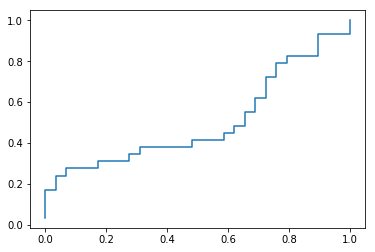

In [26]:
r = roc_curve(shufLab, predicted[:,1])
plt.plot(r[0],r[1])

In [11]:
# Do data import
normDir = "./data/nlst"
normDat = importDir(normDir)
abDir = "./data/rlst"
abDat = importDir(abDir)
inData = np.concatenate([normDat[:abDat.shape[0]], abDat]) # Normal and abnormal data same number of ppts

# Do labelling
normLab = np.zeros(normDat.shape[0])[:abDat.shape[0]]
abLab = np.ones(abDat.shape[0])
labels = np.concatenate([normLab, abLab])
    
# Mutual shuffle
shufData, shufLab = sklearn.utils.shuffle(inData, labels, random_state=1)
shufData = np.reshape(shufData,(-1,34,34,34,2))
shufLabOH = np.eye(2)[labels.astype(int)] # One hot encode

NameError: global name 'glob' is not defined

In [26]:
print(np.where(a[4]==1))
print(np.where(a[3]==1))
tprd = [a[3][0:249], a[3][249:492], a[3][492:]]
fprd = [a[4][0:249], a[4][249:492], a[4][492:]]

(array([248, 491, 733]),)
(array([247, 248, 490, 491, 732, 733]),)


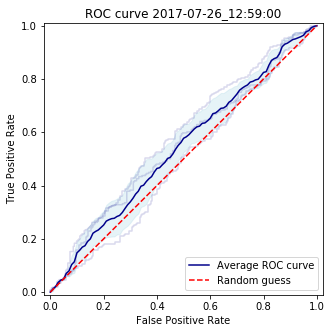

In [31]:
k = 3
# Postprocessing (specificity, sensitivity, roc curves)
dt = str(datetime.datetime.now().replace(second=0, microsecond=0).isoformat("_"))

plt.figure(figsize=(5, 5))

tprs = []
ssa = []
tft = []

base_fpr = np.linspace(0, 1, 101)

for i in np.arange(k):
    fpr = fprd[i]
    tpr = tprd[i]
    plt.plot(fpr, tpr, alpha=0.15, color="darkblue")
    tpr = interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs.append(tpr)

tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std

plt.plot(base_fpr, mean_tprs, color="darkblue", label="Average ROC curve")
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='lightblue', alpha=0.3)

plt.plot([0, 1], [0, 1],'r--', label="Random guess")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC curve '+dt)
plt.legend(loc=4)
plt.axes().set_aspect('equal', 'datalim')
#plt.savefig("./figures/rocCurves/"+dt+"-3dCNNfakedat500epoch.png")